In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',100)

In [4]:
'''Import data'''
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

In [5]:
train.shape, test.shape

((891, 12), (418, 11))

In [6]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [8]:
train.shape, test.shape

((891, 12), (418, 11))

### Pre-Processing

In [9]:
data = pd.concat([train, test], axis=0)
data.shape

(1309, 12)

In [10]:
data['Ticket_type'] = data['Ticket'].apply(lambda x: x[0:3])
data['Ticket_type'] = data['Ticket_type'].astype('category')
data['Ticket_type'] = data['Ticket_type'].cat.codes

In [11]:
data['Name_Words'] = data['Name'].apply(lambda x: len(x.split()))

In [12]:
data['Cabin'] = data['Cabin'].apply(lambda x: '1' if type(x) == float else '0')

In [13]:
data['Cnt_family'] = data['SibSp'] + data['Parch']+1
data['Single'] = data['Cnt_family'].apply(lambda x: '1' if x==1 else '0')

In [14]:
data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
#Replace the column name
data['Title'] = data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Don', 'Sir', 'Dona',
                                       'Countess', 'Capt', 'Jonkheer', 'Lady', 'the Countess'], value = 'Other')
data['Title'] = data['Title'].replace(['Ms','Mlle'], value = 'Miss')
data['Title'] = data['Title'].replace(['Mme'], value = 'Mrs')

In [15]:
data['Sex'] = data['Sex'].map({'male' : '1', 'female' : '0'})

In [16]:
#drop the non-required columns
data.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)

In [17]:
data.head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Ticket_type,Name_Words,Cnt_family,Single,Title
0,1,0.0,3,1,22.0,7.2500,1,S,139,4,2,0,Mr
1,2,1.0,1,0,38.0,71.2833,0,C,154,7,2,0,Mrs


### Missing value

In [18]:
data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age            263
Fare             1
Cabin            0
Embarked         2
Ticket_type      0
Name_Words       0
Cnt_family       0
Single           0
Title            0
dtype: int64

In [19]:
'''Impute fare missing value'''
data['Fare'].fillna(data['Fare'].median(), inplace=True)

In [20]:
'''Impute Embarked'''
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

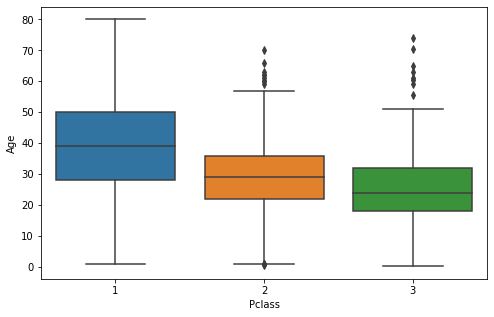

In [21]:
'''Age imputation'''
plt.figure(figsize=(8,5))
sns.boxplot(x='Pclass', y='Age', data=data)
plt.show()

In [22]:
def age_impute(cols):
    age=cols[0]
    pclass=cols[1]
    if pd.isnull(age):
        if pclass == 1: return 37
        elif pclass == 2: return 29
        else: return 24
    else: return age

data['Age'] = data[['Age', 'Pclass']].apply(age_impute, axis=1)

In [23]:
data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
Fare             0
Cabin            0
Embarked         0
Ticket_type      0
Name_Words       0
Cnt_family       0
Single           0
Title            0
dtype: int64

In [24]:
#drop the non-required columns
train = data[:891]
test = data[891:]

train.drop(columns=['PassengerId'], inplace=True)
test.drop(columns=['Survived'], inplace=True)

In [25]:
'''Split the data'''
X = train.drop(['Survived'], axis=1)[:891]
y = train['Survived'][:891]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 11), (712,), (179, 11), (179,))

### Model Building

In [28]:
ct = ColumnTransformer(
                    transformers=[
                        ('scaler', StandardScaler(), ['Age', 'Fare']),
                        ('encoder', OneHotEncoder(sparse=False), ['Pclass','Embarked', 'Title'])
                    ],
                    remainder='drop')

In [29]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

In [30]:
#Now let us contruct some pipelines of our choice.

pipe_lr = Pipeline([                             # Logistic Regression
                ('Preprocessing', ct),
                ('clf', LogisticRegression())
                ])     # Logistic Regression
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Pclass', 'Embarked',
                                                   'Title'])])),
                ('clf', LogisticRegression())])

In [31]:
pipe_rf = Pipeline([                               # RandomForest Classifier
            ('Preprocessing', ct),
            ('clf', RandomForestClassifier())])   
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Pclass', 'Embarked',
                                                   'Title'])])),
                ('clf', RandomForestClassifier())])

In [32]:
pipe_svm = Pipeline([                              # SVM Class
            ('Preprocessing', ct),
            ('clf', svm.SVC())])                  
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('encoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Pclass', 'Embarked',
                                                   'Title'])])),
                ('clf', SVC())])

### Hyperparameter tuning

In [33]:
# Set grid search params
param_range = [9, 10]
param_range_fl = [1.0, 0.5]

grid_params_lr = [{
                    'Preprocessing__scaler': [StandardScaler(), PowerTransformer()],
                    'clf__penalty': ['l1', 'l2'],
                    'clf__C': param_range_fl,
                    'clf__solver': ['liblinear']}] 


grid_params_rf = [{
                    'Preprocessing__scaler': [StandardScaler(), PowerTransformer()],
                    'clf__criterion': ['gini', 'entropy'],
                    'clf__max_depth': [5,7,9],
                    'clf__min_samples_split': [10,20]}]

grid_params_svm = [{
                    'Preprocessing__scaler': [StandardScaler(), PowerTransformer()],
                    'clf__kernel': ['linear', 'rbf'], 
                    'clf__C': range(1,10)}]

# Construct grid searches
jobs = -1

LR = GridSearchCV(estimator=pipe_lr,
                  param_grid=grid_params_lr,
                  scoring='accuracy',
                  cv=10) 



RF = GridSearchCV(estimator=pipe_rf,
                  param_grid=grid_params_rf,
                  scoring='accuracy',
                  cv=10, 
                  n_jobs=jobs)


SVM = GridSearchCV(estimator=pipe_svm,
                   param_grid=grid_params_svm,
                   scoring='accuracy',
                   cv=10,
                   n_jobs=jobs)



# List of pipelines for iterating through each of them
grids = [LR,RF,SVM]

# Creating a dict for our reference
grid_dict = {
                0: 'Logistic Regression', 
                1: 'Random Forest',
                2: 'Support Vector Machine'
            }

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(X_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
#     print(classification_report(y_pred, y_test))
#     print(confusion_matrix(y_pred, y_test))
#     print('------------------------------------------------------------------------------------------------')
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Best params are : {'Preprocessing__scaler': PowerTransformer(), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.802
Test set accuracy score for best params: 0.810 

Estimator: Random Forest
Best params are : {'Preprocessing__scaler': PowerTransformer(), 'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_split': 20}
Best training accuracy: 0.829
Test set accuracy score for best params: 0.838 

Estimator: Support Vector Machine
Best params are : {'Preprocessing__scaler': PowerTransformer(), 'clf__C': 1, 'clf__kernel': 'rbf'}
Best training accuracy: 0.817
Test set accuracy score for best params: 0.838 

Classifier with best test set accuracy: Random Forest


### Final Model

In [34]:
# Save best grid search pipeline to file
import joblib
dump_file = 'model.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))


Saved Random Forest grid search pipeline to file: model.pkl


In [36]:
#Loading the saved model with joblib
model = joblib.load('model.pkl')

# New data to predict
pred_cols = list(test.columns.values)[1:]

# apply the whole pipeline to data
pred = pd.DataFrame({'Survived' : model.predict(test[pred_cols])})
pred.head()

,Survived
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0


In [37]:
# Prediction file
pred_df = pd.concat([submit['PassengerId'], pred], axis=1)
pred_df['Survived'] = pred_df['Survived'].apply(lambda x: str(int(x)))

display(pred_df.head())
pred_df.info()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  418 non-null    int64 
 1   Survived     418 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.7+ KB
